# Guided Grad-CAM

Guided backpropagation is a combination of the gradient and deconvolution attribution methods. The deconvolution method discussed in [Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps](https://arxiv.org/abs/1312.6034), was shown to be equivalent to a backward pass through the network, except for its interaction with the relu layer. The negative gradient values would be zeroed by relu, but the gradient values coming from negative input image values were not zeroed. Guided backpropagation method adapts this idea by **zeroing both negative gradients and gradients coming from negative input values**. We will implement this method by introducing a new relu layer called guided relu. Unfortunately guided relu performs poorly when training, so the model will first be trained with relu layers, then the relu layers will be swapped out for the guided relu layers when evaluating the attribution maps. There is no obvious way to swap layers in flax, so instead we will define a new model with the same architecture but guided relu inplace of relu layers.  

For more technical information on the guided backpropagation attribution method see: [Striving for Simplicity: The All Convolutional Net](https://arxiv.org/abs/1412.6806)


In [25]:
import os
import sys

notebook_dir = os.path.dirname(os.path.abspath('__file__'))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jax.numpy as jnp


import jax
from jax import random
from jax import grad
import optax

import requests
import zipfile
import flaxmodels
from PIL import Image
from flax.core.frozen_dict import freeze

from utils.image import *
from utils.plot import plot_image, plot_all_images
from utils.guided_relu import guided_relu


from utils.classification import get_predictions




In [26]:
image_path = './storage/datasets/imagenet/train/n01514859/n01514859_69.JPEG'
import os
os.getcwd() 

'/workspaces/feature-attribution-methods-jax'

### Load training data
Check if the training data exists. If not, automatically download it.

In [27]:
rgb_img = cv2.imread(image_path, 1)[:, :, ::-1] # `::-1`: Selects all channels but in reverse order, resulting in the RGB image.
rgb_img = np.float32(rgb_img) / 255
    
preprocessed_img = preprocess_image(rgb_img)
input_tensor = jnp.expand_dims(preprocessed_img, axis=0) # Whether to use preprocessing


H, W, C = (500, 333, 3)


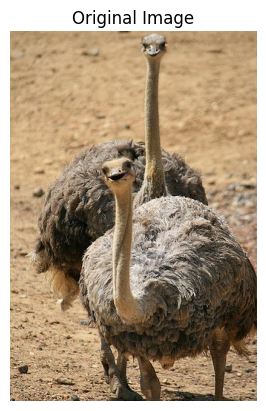

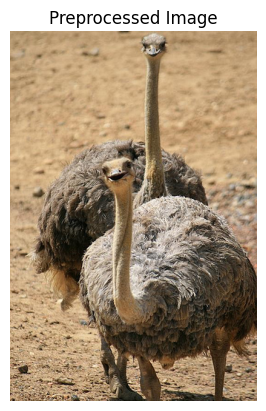

In [28]:

    
H, W, C = rgb_img.shape
print(f"H, W, C = {rgb_img.shape}")
plot_image(rgb_img, title='Original Image')
plot_image(preprocessed_img, title='Preprocessed Image')


# Create model with grad-cam hook

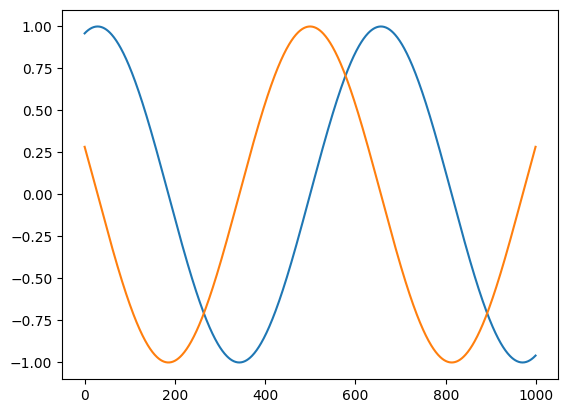

In [29]:
input_vector = jnp.linspace(-5, 5, 1000)

plt.plot(jnp.sin(input_vector))
plt.plot(jax.vmap(grad(jnp.sin))(input_vector))

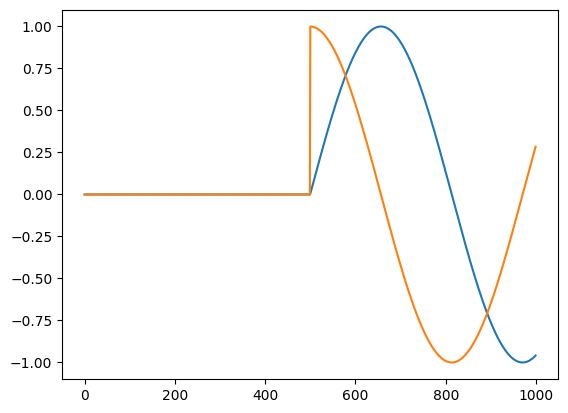

In [30]:
def relu_sin(x):
    x = jax.nn.relu(x)
    return jnp.sin(x)

plt.plot(relu_sin(input_vector))
plt.plot(jax.vmap(grad(relu_sin))(input_vector))

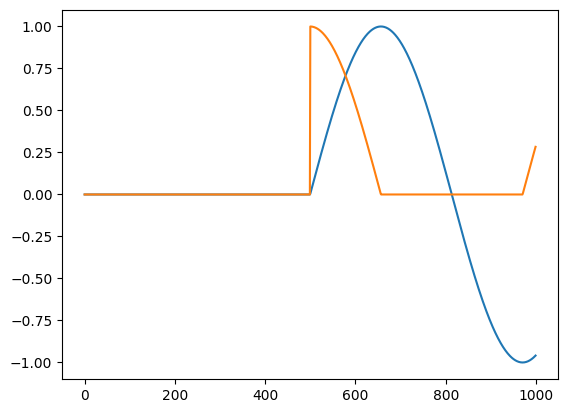

In [31]:
def guided_relu_sin(x):
    x = guided_relu(x)
    return jnp.sin(x)

plt.plot(guided_relu_sin(input_vector))
plt.plot(jax.vmap(grad(guided_relu_sin))(input_vector))

In [32]:
guided_grad_cam_model = flaxmodels.ResNet50Customized(output='logits', pretrained='imagenet', customized_relu=guided_relu, use_observed_layer=True)
vanilla_model = flaxmodels.ResNet50(output='logits', pretrained='imagenet')

rng_key = random.PRNGKey(0)

variables = guided_grad_cam_model.init(rng_key, input_tensor) # {'params': ..., 'batch_stats': ..., 'perturbations': ...}

logits = guided_grad_cam_model.apply(variables, input_tensor, train=False)
prediction = get_predictions(logits)
print(prediction) # probabilities for 1000 classes

# print(model.tabulate(rng_key, input_tensor))
# print(variables)


[9]


In [33]:
# model_with_guided_relu = flaxmodels.ResNet50Guided(output='logits', pretrained='imagenet', )


### Display predictions and attribution maps

The final convolutional layer values and gradients are required to perform Grad-CAM. To access the convolutional layer it needs to be stored as an intermediate variable in the model definition, then the "mutable='intermediates'" argument is supplied to the model when performing the forward pass. The gradients of the final convolutional layer is extracted by passing the final convolutional layers values as a perturbation parameter to the loss function, then calculating the gradients of the perturbation parameter. Global average pooling is then applied to the convolutional layers gradients to extract the weightings. This is performed by taking the mean of each filter/feature map, this results in a vector of floats with the size of the number of feature maps. The vector is then used as weights for the feature maps. The dot product is taken between the weights and feature maps to provide us with the class activation mapping. 

### Create new loss function with guided model

A new loss function containing the model with guided relu layers is required when performing gradient calculations for the attribution attribution maps.

In [34]:
def loss_fn(model, params, batch_stats, perturbations, X, Y):
    '''
    Classification loss function.
    In both Guided BP and Grad-CAM , we want to get the grad of the last layer w.r.t. the target label, instead of the loss.
    To do this, we still define the loss function, but we use the negated gradients, since d(-L) / dx == - d(L) / dx
    '''
    variables = {
        'params': params,
        'batch_stats': batch_stats,
        'perturbations': perturbations
    }
    
    logits = model.apply(variables, X, train=False)
    predictions = get_predictions(logits)
    
    logit_for_pred = logits[0, predictions[0]]
    loss = optax.softmax_cross_entropy_with_integer_labels(logits, Y)
    loss = loss.mean()
    return loss

### Display predictions and attribution maps

The gradients are calculated with the new guided loss function. The gradients are then normalized in the standard way for visualization.

In [35]:
def make_predictions(model, variables, X):
    logits, state = model.apply(variables, X, train=False, mutable='intermediates')
    predictions = get_predictions(logits)
    return predictions, state

    

def display_prediction(model, variables, rgb_img, input_tensor, vanilla_model, target=None):
    prediction, state = make_predictions(model, variables, input_tensor)
    # Extract final conv layers values
    final_conv_layer_activations = state["intermediates"]["gradcam_sow"][0]
    
    if target is None:
        target = prediction
    print("Prediction: ", prediction)
    print("Target: ", target)
    
    # For input image
    B, H, W, C = input_tensor.shape
    assert B==1
    plot_image(input_tensor[0], title='Preprocessed Image')
    
    
    #################################################
    # Grad-CAM
    #################################################
    perturbations = freeze({"gradcam_perturb": final_conv_layer_activations}) # This is the perturbation that we will use to extract the gradients.
    final_conv_grads = grad(loss_fn, argnums=3)(model, variables['params'], variables['batch_stats'], perturbations, input_tensor, target) # Use negated grad
    final_conv_grads = -final_conv_grads["gradcam_perturb"] # Here I use the negated gradients w.r.t. the classificaiton loss to get the positive contributions.
    
    # Get weights using global average pooling
    weights = jnp.mean(final_conv_grads, axis=(1, 2))# (B, H', W', C') -> (B, H'*W'*C') 
    # Get the weighted sum of all the filters
    
    weighted_activations = weights[:, None, None, :] * final_conv_layer_activations 
    
    target_size = (W, H)
    cam = jnp.sum(weighted_activations, axis=-1) # (B, H', W', C') --> (B, H', W') now it's gray scale image
    cam = jnp.maximum(cam, 0) # They take only the positive contributions by applying a RELU function:
    scaled = scale_cam_image(cam, target_size) # (B, H, W)
    
    grayscale_cam = scaled[0, :]
    #################################################
    #################################################
    
    # After Grad-CAM, we need to clear intermediates to avoid feed it back into `variables`. 
    # See https://flax.readthedocs.io/en/latest/guides/model_inspection/extracting_intermediates.html
    variables['perturbations']  = {key: jnp.zeros_like(value) for key, value in perturbations.items()}
    
    #################################################
    # Vanila Gradient Method
    #################################################
    attributions_map = -grad(loss_fn, argnums=4)(vanilla_model, variables['params'], variables['batch_stats'], variables['perturbations'], input_tensor, target) # negated grad
    attributions_map = attributions_map[0, :]
    #################################################
    #################################################
    
    
    #################################################
    # Guided BP 
    #################################################
    guided_attributions_map = -grad(loss_fn, argnums=4)(model, variables['params'], variables['batch_stats'], variables['perturbations'], input_tensor, target) # negated grad
    guided_attributions_map = guided_attributions_map[0, :]
    #################################################
    #################################################
    
    
    #################################################
    # Guided Grad-CAM
    #################################################
    cam_mask = cv2.merge([grayscale_cam, grayscale_cam, grayscale_cam])
    guided_cam_image = cam_mask * guided_attributions_map
    #################################################
    #################################################
    
    # Visualization
    cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
    attributions_map = deprocess_image(attributions_map)
    guided_attributions_map = deprocess_image(guided_attributions_map)
    guided_cam_image = deprocess_image(guided_cam_image)

    plot_all_images(cam_image, attributions_map, guided_attributions_map, guided_cam_image)


Prediction:  [9]
Target:  [9]


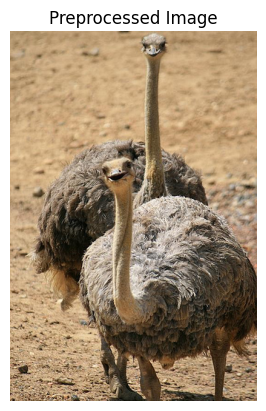

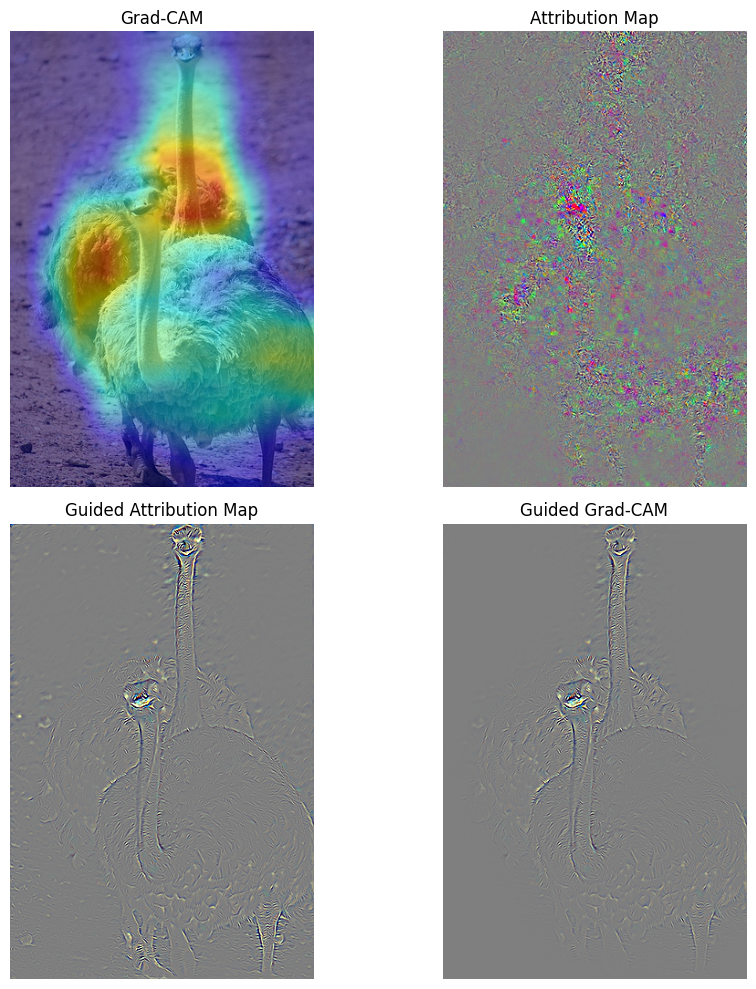

In [36]:
display_prediction(guided_grad_cam_model, variables, rgb_img, input_tensor, vanilla_model, target=None)